IMPORTING REQUIRED PACKAGES

In [1]:
import numpy as np
import pandas as pd
import json
import re
import glob

from tqdm import tqdm
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

DEFINING ALL REQUIRED FUNCTIONS:
    1. extractText : extracts the title, abstract and body from the paper
    2. nonAscii_remover : removes the ascii characters from the text
    3. Letter_remover : removes single letters from the text (got the idea to keep 'a' and 'i' after discussing with others)
    4. Punctuation_remover : removes all punctuation
    5. HTML_remover : Removes HTML links
    6. Numbers_remover : Removes numbers not a part of other words 

In [2]:
def extractText(filename): 

    file = open(filename)
    content = json.load(file)

    title = ""
    abstract = ""
    body = ""

    if 'title' in content['metadata']:
        title = content['metadata']['title']
    if 'abstract' in content:
        for abs in content['abstract']:
            abstract = abstract + abs['text']
    if 'body_text' in content:
        for bt in content['body_text']:
            body = body + bt['text']

    return title.lower(), abstract.lower(), body.lower()

def nonAscii_remover(x): 
    cleared = ''.join(filter(lambda y: (ord(y) <= 128), x))
    return cleared.strip()

def Letter_remover(x):
    regex = re.compile(r'\W*\b[b-hj-zB-HJ-Z]{1}\b')
    cleared = re.sub(regex, '', x)
    return cleared.strip()

def Punctuation_remover(x):
    regex = re.compile(r'[^\w\s.?!-]')
    cleared = re.sub(regex, ' ', x)
    return cleared.strip()

def HTML_remover(x):
    regex = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleared = re.sub(regex, '', x)
    return cleared.strip()

def Numbers_remover(x):
    regex = re.compile(r'\b(?<![0-9-])(\d+)(?![0-9-])\b')
    cleared = re.sub(regex, '', x)
    return cleared.strip()

lemmatizer = WordNetLemmatizer()

In [5]:
json_files = glob.glob('C:/Users/tomam/Documents/NLP/Assignments/pdf_json/*.json',recursive=True)

In [6]:
def text_cleaner(*argv): 
    
    sentence = ""
    
    for arg in argv:
        arg = nonAscii_remover(arg)
        arg = Letter_remover(arg)
        arg = Punctuation_remover(arg)
        arg = HTML_remover(arg)
        arg = Numbers_remover(arg)
        arg = ' '.join([lemmatizer.lemmatize(word) for word in arg.split()])
        sentence = sentence + arg + '. '
        
    sentence = sentence[:len(sentence)-2]
    
    return sentence.strip() + '\n'

In [7]:
corpus = open('CovCorpus.txt','w') 

In [8]:
rng = np.random.default_rng()
samples = rng.choice(len(json_files), size=15000, replace=False)

In [9]:
min_length = 5
max_length = 20

for i in tqdm(samples):
    
    title, abstract, body = extractText(json_files[i])
    title = title.replace('\n', '')
    abstract = abstract.replace('\n', '')
    body = body.replace('\n', '')
    
    cleared = text_cleaner(title, abstract, body)
    threshold_sentence = [x.strip()+'\n' for x in cleared.split('.') if len(x.split()) >= min_length and len(x.split()) <= max_length]
    
    for word in threshold_sentence:
        corpus.write(word)

print(corpus)        
corpus.close()

100%|██████████| 15000/15000 [07:03<00:00, 35.45it/s]

<_io.TextIOWrapper name='CovCorpus.txt' mode='w' encoding='cp1252'>


In [10]:
corpus = open('CovCorpus.txt','r')
CovCorpus = corpus.read()
corpus.close()

docs = CovCorpus.split('\n')
docs.pop()

''

In [11]:
vocab = set()
vocabFreqDict = {}
vocabCount = 0
wordCount = 0
cumulativesum_vocab = []
cumulativesum_word = []

for doc in tqdm(docs): 
    words = doc.split()    
    for word in words:
      wordCount += 1
      word = word.lower()
      if word not in vocab:
          vocab.add(word)
          vocabFreqDict[word] = 1
          vocabCount += 1
      else:
          vocabFreqDict[word] += 1

    cumulativesum_vocab += [vocabCount]
    cumulativesum_word += [wordCount]

100%|██████████| 1441550/1441550 [00:21<00:00, 65731.80it/s]


In [12]:
wordRank = pd.DataFrame(sorted(vocabFreqDict.items(), key=lambda x: x[1], reverse=True), columns = ['Word', '# Occurences'], index = range(1,len(vocab)+1))
wordRank.index.name = 'Rank'
wordRank[:100]

,Word,# Occurences
Rank,,
1,the,1047837
2,of,687575
3,and,559508
4,in,497029
5,a,419767
...,...,...
96,first,18495
97,health,18347
98,should,18338


Calculating alpha value

In [13]:
alpha = 0 
for i in tqdm(range(2, len(wordRank)+1)):
    x = wordRank.loc[1][1]/wordRank.loc[i][1]
    alpha += np.log(x)/np.log(i)
alpha = alpha/len(wordRank)
print('\n', alpha)

100%|██████████| 394925/394925 [01:14<00:00, 5269.30it/s]


 1.0953115056018483


In [14]:
heapLaw = [] 
for i in cumulativesum_word:
    heapLaw += [30*(i)**0.55]

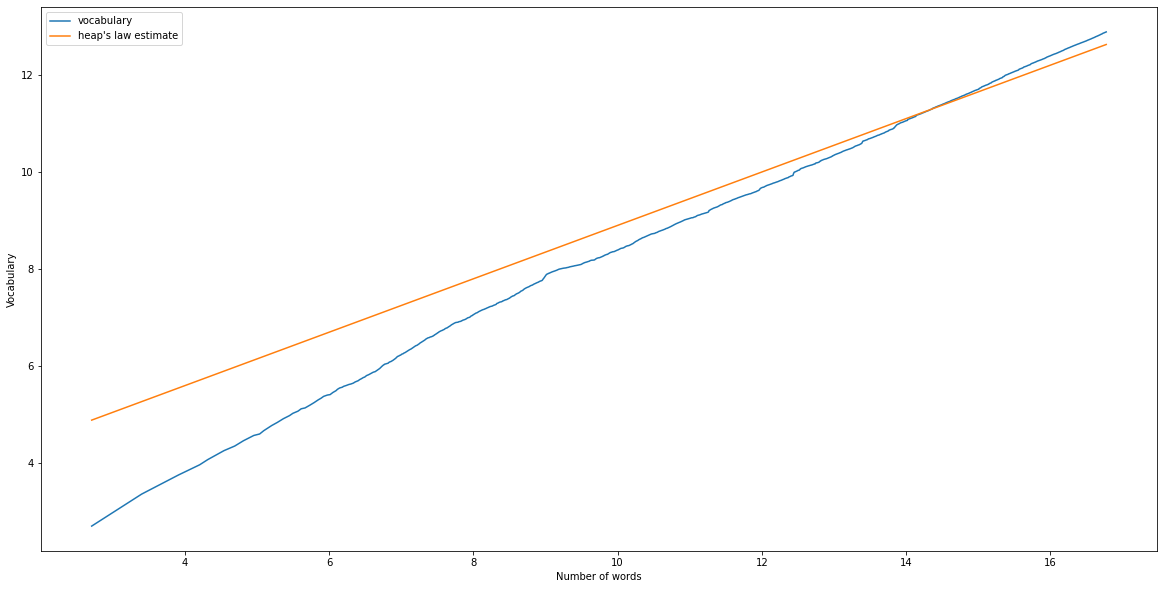

In [15]:
plt.figure(figsize = (20,10))
plt.plot(np.log(cumulativesum_word),np.log(cumulativesum_vocab),label = 'vocabulary')
plt.plot(np.log(cumulativesum_word),np.log(heapLaw),label = 'heap\'s law estimate')
plt.xlabel("Number of words")
plt.ylabel("Vocabulary")
plt.legend()
plt.show()